In [238]:
import numpy as np

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Load dataset

In [239]:
import polars as pl
from sklearn.model_selection import train_test_split

RANDOM_SEED = 777
TRAIN_RATIO = 0.8

df: pd.DataFrame = pl.read_parquet("data.parquet.zstd").to_pandas()
train_df, test_df = train_test_split(df, train_size=0.8, random_state=RANDOM_SEED)

In [240]:
train_df["is_offensive"] = pd.Categorical((train_df["off_relaxed"].astype(int))).codes
test_df["is_offensive"] = pd.Categorical((test_df["off_relaxed"].astype(int))).codes

train_df = train_df[["text", "is_offensive"]]
test_df = test_df[["text", "is_offensive"]]

In [241]:
import re
from unidecode import unidecode
import spacy

from tqdm import tqdm
nlp = spacy.load("pt_core_news_sm")
lemma = lambda x : x.lemma_

# Normalização dos textos
for i,row in tqdm(df.iterrows(), total=df.shape[0]):
    temp =  row['text'].lower()

    # Remoção de vírgulas, aspas, emojis, quebras de linha
    temp = re.sub(r'[^\w\s]|[\n]', '',temp)
    # Lematização
    temp = " ".join(list(map(lemma, nlp(temp))))
    # Removeção de acentos, cedilhas e semelhantes
    temp = unidecode(temp)

    df.loc[i,'text'] = temp

100%|██████████| 27952/27952 [04:08<00:00, 112.30it/s]


In [242]:
pd.options.display.max_colwidth = 20000
pd.options.display.min_rows = 10
pd.options.display.max_rows = 10
display(test_df[test_df.is_offensive == 1].sample(frac=1))

,text,is_offensive
11359,caralho pqp brasil só mais quatro pontos porra,1
12042,puta que pariu cacete de vôlei aaaaaaaaa,1
22230,USER políticos são tds ladrão sem exceção de partido,1
23690,USER covarde NOJENTA USER👊👊👊👊👊👊👊👊💪,1
22056,O cara tentando falar e os dois tá tipo FODA USER KAKAKAKAKKAKAKAKKAAK,1
...,...,...
26954,tropa de ladrão nesse momento que o USER ta passando ficam brigando os cachorros,1
16864,"a pessoa eh babaca com vc e ainda se sente no direito de se sentir ofendido pq vc n quer mais flar com ele, vai pra casa do caralho",1
11053,"rt USER não tenho coração pra esse vôlei mais!! pqp, vamo meninaaas",1
11365,rt USER agnaldo n quer dá o cu pra bia.\n\npoxa agnaldo,1


In [243]:
from nltk.corpus import stopwords
from nltk import download
# download('stopwords')
stop_words = stopwords.words('portuguese')

In [244]:
from gensim.models import KeyedVectors

EMBEDDING_SIZE: int = 300
EMBEDDING_FILE: str = 'glove_s300.txt'
word2vec: KeyedVectors = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=False)

In [245]:
def preprocess(sentence: str) -> list[float]:
    return [w for w in sentence.lower().split() if w not in stop_words]

def get_cases(df: pd.DataFrame, sequence_length: int = 150) -> tuple[np.ndarray, np.ndarray]:
    word_embeddings = []
    for _, row in df.iterrows():
        sentence = preprocess(row['text'])
        L = []
        for token in sentence:
            if len(L) == sequence_length:
                break

            try:
                L.append(word2vec[token])
            except:
                L.append([0] * EMBEDDING_SIZE)

        while len(L) < sequence_length:
            L.append([0] * EMBEDDING_SIZE)

        word_embeddings.append(L)

    y: np.ndarray = df["is_offensive"].to_numpy()

    return np.array(word_embeddings), y

In [246]:
SEQUENCE_LENGTH: int = 80

X_train, y_train = get_cases(train_df, sequence_length = SEQUENCE_LENGTH)
X_test, y_test = get_cases(test_df, sequence_length = SEQUENCE_LENGTH)

print(sum(y_train), len(y_train)-sum(y_train))
print(sum(y_test), len(y_test)-sum(y_test))

8429 13932
2067 3524


In [247]:
BATCH_SIZE: int = 32

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train).unsqueeze(dim=-1)
y_test = torch.FloatTensor(y_test).unsqueeze(dim=-1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([22361, 80, 300])
torch.Size([5591, 80, 300])
torch.Size([22361, 1])
torch.Size([5591, 1])


In [248]:
class ModelClass(nn.Module):
    def __init__(self, sequence_length: int, hidden_size: int):
        super().__init__()

        # self.rnn = nn.RNN(EMBEDDING_SIZE, hidden_size, bidirectional=True, batch_first=True, bias=True)

        self.flat = nn.Flatten()
        # self.fc1 = nn.Linear(2 * hidden_size * sequence_length, sequence_length, bias=True)

        self.fc1 = nn.Linear(sequence_length * EMBEDDING_SIZE, 2*sequence_length, bias=False)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(2*sequence_length, 1, bias=False)

    def forward(self, x):
        # x, _ = self.rnn(x)
        x = self.flat(x)
        x = self.act1(self.fc1(x))
        x = self.fc2(x)
        return x

In [249]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ModelClass(SEQUENCE_LENGTH, 8)
model = model.to(device)

cpu


In [250]:
THRESHOLD: float = 0.55

LEARNING_RATE: float = 0.0001
optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = torch.Tensor([(len(y_train)-sum(y_train))/sum(y_train)]))

In [251]:
N_EPOCHS: int = 150

train_losses: list[float] = []
test_losses: list[float] = []
test_acc: list[float] = []

for epoch in range(N_EPOCHS):
    y_hat = model(X_train)
    loss = loss_fn(y_hat, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(float(loss))

    with torch.no_grad():
        y_hat = model(X_test)
        loss = loss_fn(y_hat, y_test)

        acc = np.sum((y_test.numpy() == (y_hat.numpy() > THRESHOLD).astype(int)).astype(float))/len(y_test)

        test_acc.append(acc)
        test_losses.append(float(loss))

    print(f"Epoch: {epoch+1} | Train Loss: {train_losses[-1]} | Test Loss: {test_losses[-1]} | Acc: {test_acc[-1]}")

torch.save(model.state_dict(), "rnn_model3.pt")

Epoch: 1 | Train Loss: 0.8642237782478333 | Test Loss: 0.855675220489502 | Acc: 0.6302986943301735
Epoch: 2 | Train Loss: 0.8570439219474792 | Test Loss: 0.8513886332511902 | Acc: 0.6302986943301735
Epoch: 3 | Train Loss: 0.8509977459907532 | Test Loss: 0.8474746942520142 | Acc: 0.6320872831336076
Epoch: 4 | Train Loss: 0.8454829454421997 | Test Loss: 0.8437733054161072 | Acc: 0.6335181541763548
Epoch: 5 | Train Loss: 0.8402647376060486 | Test Loss: 0.8402207493782043 | Acc: 0.6347701663387587
Epoch: 6 | Train Loss: 0.8352590203285217 | Test Loss: 0.8367512822151184 | Acc: 0.6372741906635665
Epoch: 7 | Train Loss: 0.8303983211517334 | Test Loss: 0.8332897424697876 | Acc: 0.6388839205866571
Epoch: 8 | Train Loss: 0.8256264328956604 | Test Loss: 0.8298004269599915 | Acc: 0.6403147916294044
Epoch: 9 | Train Loss: 0.8209078311920166 | Test Loss: 0.8262696862220764 | Acc: 0.6415668037918083
Epoch: 10 | Train Loss: 0.8162396550178528 | Test Loss: 0.8227434158325195 | Acc: 0.6426399570738687


tensor([[-2.3230],
        [-0.0176],
        [-1.0192],
        [-0.2294],
        [ 0.5128],
        [-1.2854],
        [-0.7839],
        [ 0.2681],
        [-4.6621],
        [-0.0753],
        [ 1.4082],
        [-0.7760],
        [-1.3770],
        [ 0.9899],
        [-0.5768],
        [-0.3960],
        [-1.9315],
        [-0.4611],
        [-0.5584],
        [-0.3721]], grad_fn=<SliceBackward0>)


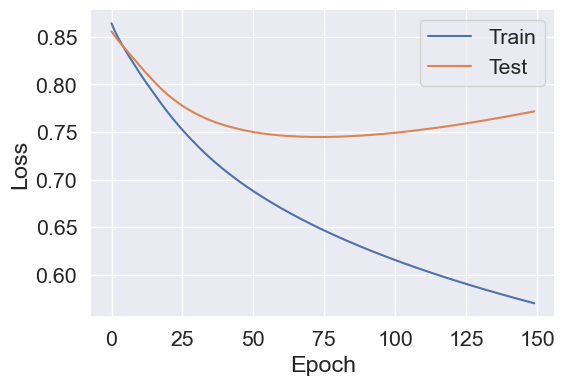

In [258]:
import matplotlib.pyplot as plt

print(model(X_test)[0:20])

plt.figure(figsize = (6,4))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(np.arange(len(train_losses)), train_losses, label = 'Train')
plt.plot(np.arange(len(test_losses)), test_losses, label = 'Test')
plt.legend()

In [253]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

In [283]:
y_hat = model(X_test)
fixed_results = nn.Sigmoid()(y_hat).detach() > THRESHOLD
fixed_targets = y_test > THRESHOLD

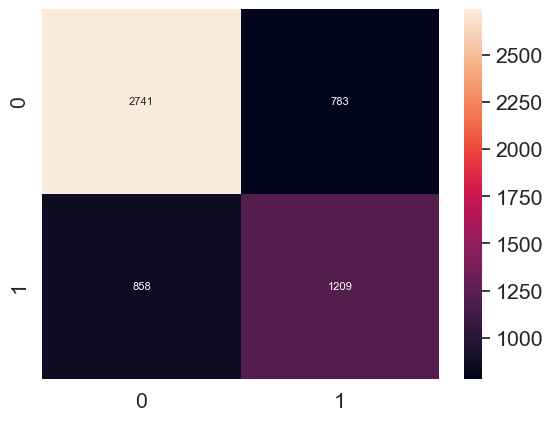

In [284]:
import seaborn as sn
tp, fp, tn, fn = confusion(fixed_results, fixed_targets)

array = [[tn, fp],
         [fn, tp]]

df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8}, fmt="d") # font size

plt.show()

In [285]:
fixed_results = fixed_results.numpy()
fixed_targets = fixed_targets.numpy()

In [286]:
from sklearn.metrics import (
    f1_score, fbeta_score, accuracy_score, recall_score, precision_score)

fixed_weighted_f1 = f1_score(fixed_targets, fixed_results, average='weighted')
fixed_macro_f1 = f1_score(fixed_targets, fixed_results, average='macro')
fixed_weighted_f2 = fbeta_score(fixed_targets, fixed_results, beta=2, average='weighted')
fixed_macro_f2 = fbeta_score(fixed_targets, fixed_results, beta=2, average='macro')
fixed_accuracy = accuracy_score(fixed_targets, fixed_results)
fixed_recall = recall_score(fixed_targets, fixed_results, average='weighted')
fixed_precision = precision_score(fixed_targets, fixed_results, average='weighted')

print("Model Metrics:")
print(f"Weighted F1 = {fixed_weighted_f1:.6f}")
print(f"Macro F1 = {fixed_macro_f1:.6f}")
print(f"Weighted F2 Score = {fbeta_score(fixed_targets, fixed_results, beta=2, average='weighted'):.6f}")
print(f"Macro F2 Score = {fbeta_score(fixed_targets, fixed_results, beta=2, average='macro'):.6f}")
print(f"Accuracy = {fixed_accuracy:.6f}")
print(f"Recall = {fixed_recall:.6f}")
print(f"Precision = {fixed_precision:.6f}")

Model Metrics:
Weighted F1 = 0.705326
Macro F1 = 0.682666
Weighted F2 Score = 0.705995
Macro F2 Score = 0.681847
Accuracy = 0.706493
Recall = 0.706493
Precision = 0.704418
